# AU Interest Rate Risk Banking Book (APS117)

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.9.8-blue">

The [Australian Prudential Regulation Authority (APRA)](https://www.apra.gov.au/) published a version of [Interest Rate Risk in Banking Book (IRRBB) capital APS117 requirements](https://www.apra.gov.au/sites/default/files/draft_prudential_standard_aps_117_capital_adequacy_interest_rate_risk_in_the_banking_book.pdf) in November 2022. This Prudential Standard sets out the requirements that banks must meet to ensure it prudently manages interest rate risk in the banking book. 

The key requirements of this Prudential Standard are that a bank must:

- have a framework to manage, measure and monitor interest rate risk in the banking book, commensurate with the nature, scale and complexity of its operations; and
- be approved by APRA to use an internal model for determining its interest rate risk in the banking book capital charge.

This notebook is designed to assist banks to calculate the IRRBB capital charge following the internal model approach documented in the standard. It includes calculations of:

1) the interest rate data
2) the prospective IRRBB capital Charge
3) the repricing assumptions
4) the optionality risk 

The solution design should cover documentation, data input, calculation, dashboards design, reporting, limit management, stress test, what-if, data export and alert.  

<img src="https://data.atoti.io/notebooks/irrbb/img/irrbb.gif" />

## References

[1]: APRA Prudential Standard APS117 (Drafted November 2022) 
https://www.apra.gov.au/sites/default/files/2022-11/Prudential%20Standard%20APS%20117%20Capital%20Adequacy%20-%20Interest%20Rate%20Risk%20in%20the%20Banking%20Book%20-%20clean.pdf


<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=irrbb" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
# Importing Atoti libraries
import datetime

import atoti as tt
from utils import data_processing, tables

### Switching between Atoti and Atoti Community Edition 

<img src="https://img.shields.io/badge/-Atoti%20CE-%23291A40" /> 🔛 <img src="https://img.shields.io/badge/🔒-Atoti-291A40" />  

Switch from Atoti Community Edition to Atoti Python SDK by updating the below variable to `True`. 

In [2]:
atoti_unlock = False

By setting the above variable to `True`, we can leverage features not available in the Community Edition, like a text editor in Atoti UI.  
**Want to try Atoti Python SDK? You can [register online for an evaluation license](https://atoti.io/evaluation-license-request/) and check out how to [unlock all features of Atoti](https://docs.atoti.io/latest/how_tos/unlock_all_features.html).**

Setting the above variable to `False` will continue to use Atoti Community Edition. No additional licensing setup is required.

In [3]:
app_ext = tt.ADVANCED_APP_EXTENSION if atoti_unlock else {}
content = "./content" if atoti_unlock else "./content-atoti-ce"

Loading the trade and contract based information for both market and non-market related items

In [4]:
session = tt.Session.start(
    tt.SessionConfig(
        port=9102,
        user_content_storage=content,
        app_extensions=app_ext,
        java_options=["-Xms1G", "-Xmx8G"],
    )
)

tbls = tables.Tables(session)

### Data model and cube creation

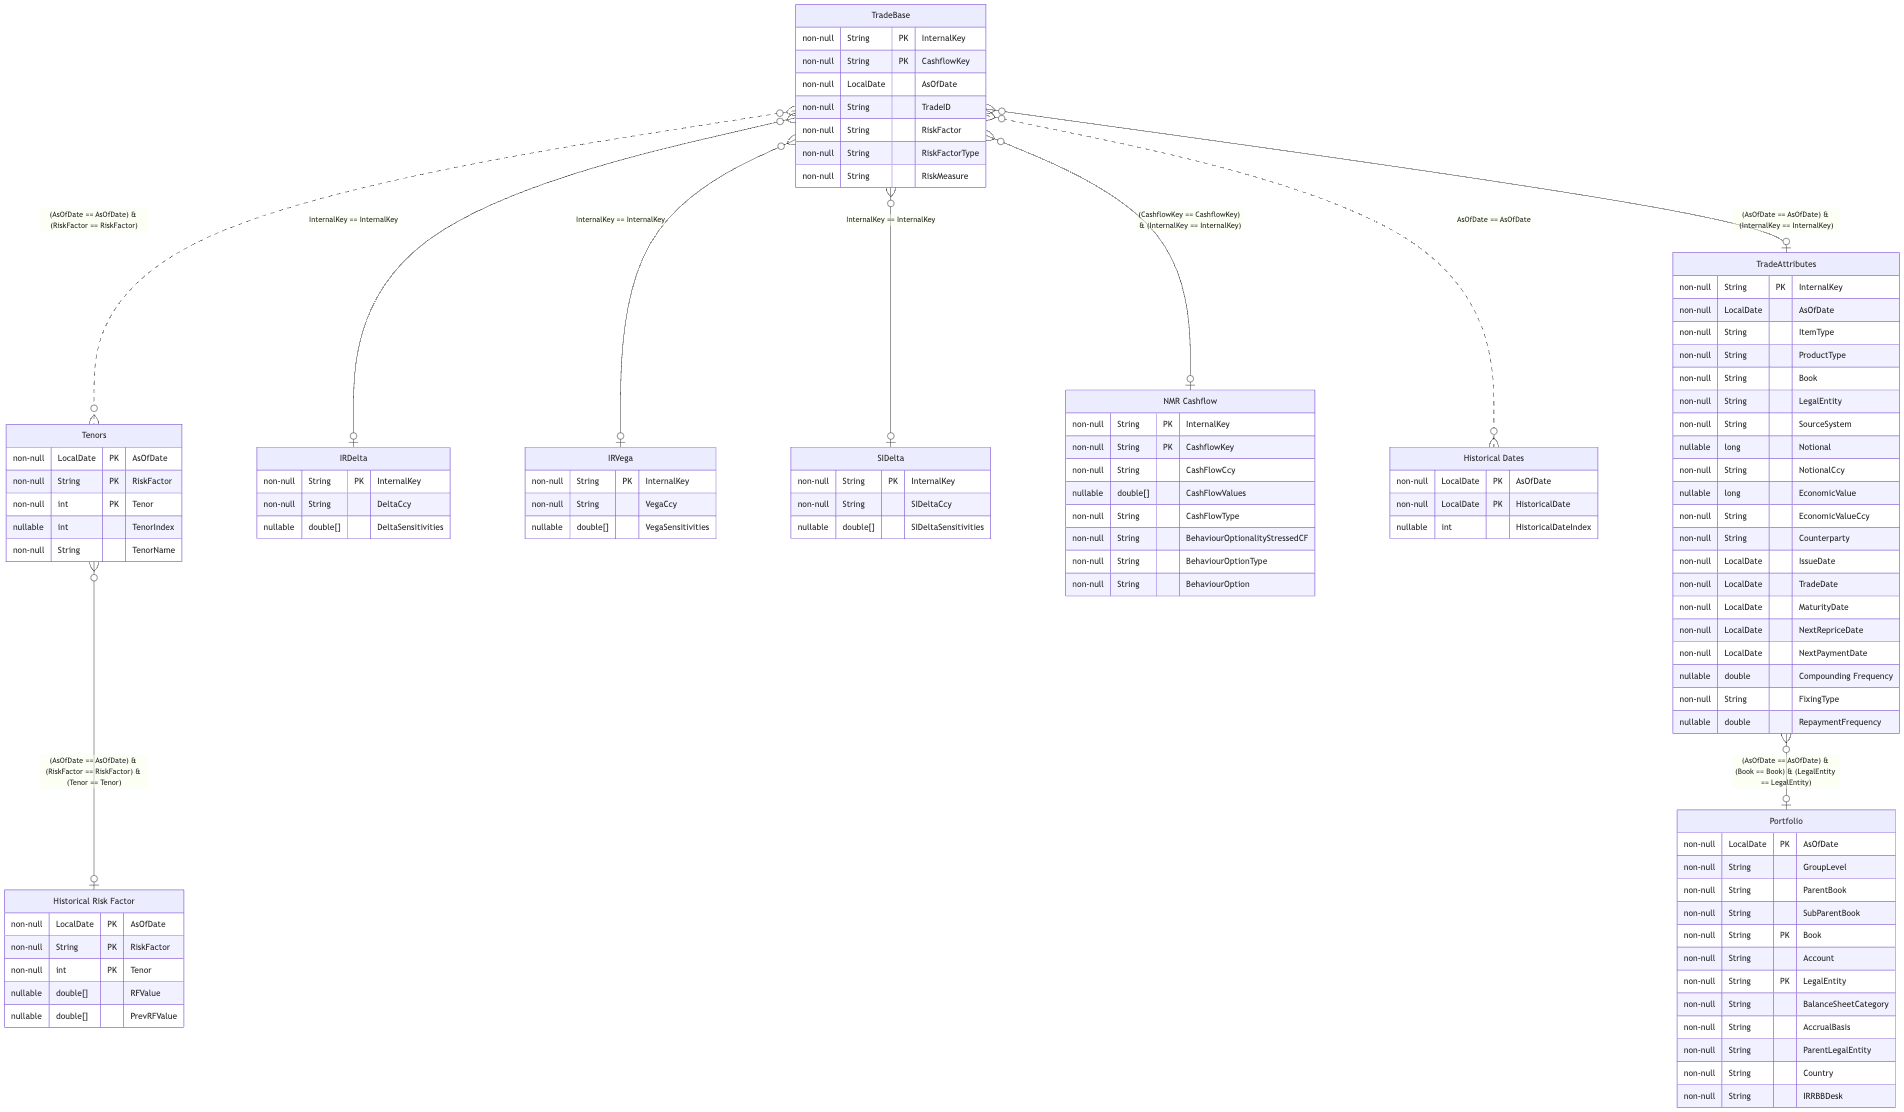

In [5]:
cube = session.create_cube(tbls.tradeBaseTbl)
session.tables.schema

In [6]:
cube.shared_context["queriesResultLimit.intermediateLimit"] = -1
cube.shared_context["queriesResultLimit.transientLimit"] = -1

In [7]:
data_processing.load_data(session, tbls)

In [8]:
# Define the dimensions of the cube
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Attachment B - Approved IRRBB models

### B.4 Classification of banking book items
For the purpose of calculating its IRRBB capital charge, an ADI must classify banking book items in accordance with paragraphs 5 to 10 of this Attachment.

### B.5-6 Market-related items:
All securities in the banking book excluding debt, Additional Tier 1 Capital and Tier 2 Capital issued by the ADI are classified as market-related items. An ADI must designate each banking book item not covered by the previous sentence as either a market-related item or a non-market-related item. The criterion for making such designations forms part of the approved IRRBB model, must be documented, and any change to it constitutes a model change that requires APRA approval.

Where an ADI holds securities issued in a securitisation:
a) if the ADI is an originating ADI of the securitisation, as defined in Prudential Standard APS 120 Securitisation, and the ADI treats the securitisation’s underlying assets as on-balance sheet assets of the ADI under Prudential Standard APS 112 Capital Adequacy: Standardised Approach to Credit Risk or Prudential Standard APS 113 Capital Adequacy: Internal Ratings-based Approach to Credit Risk, the ADI must consolidate the balance sheet of the securitisation vehicle with the ADI’s balance sheet for the purpose of this Prudential Standard; or
b) the ADI must treat the securities as market-related, otherwise.

For the Market-related items, the interest rate risk can be calculated by sensitivities and the historical interest rate movement. 

In [9]:
# Define the Tenor bucket names of the analysis

l["TenorName"].order = tt.CustomOrder(
    first_elements=[
        "Day 1",
        "Day 2",
        "Day 7",
        "Day 14",
        "Day 30",
        "Day 60",
        "Day 90",
        "Day 120",
        "Day 150",
        "Day 180",
        "Day 210",
        "Day 240",
        "Day 270",
        "Day 365",
        "Day 455",
        "Day 545",
        "Day 635",
        "Day 720",
        "Day 900",
        "Day 1095",
        "Day 1461",
        "Day 1825",
        "Day 2555",
        "Day 3650",
    ]
)

In [10]:
# Define the Tenor buckets of the analysis

l["Tenor"].order = tt.CustomOrder(
    first_elements=[
        "1",
        "2",
        "7",
        "14",
        "30",
        "60",
        "90",
        "120",
        "150",
        "180",
        "210",
        "240",
        "270",
        "365",
        "455",
        "545",
        "635",
        "720",
        "900",
        "1095",
        "1461",
        "1825",
        "2555",
        "3650",
    ]
)

In [11]:
m["EconomicValue"] = tt.agg.sum(tbls.tradeAttributeTbl["EconomicValue"])
m["Notional"] = tt.agg.sum(tbls.tradeAttributeTbl["Notional"])

### B.7-11 Non-market-related items:

B.7 A non-market-related item is classified as principal-and-interest if it:
(a) is a deposit; or
(b) can be represented to an acceptable level of accuracy as a sequence of principal and interest cash flows. For this purpose, cash flows that are economically equivalent to interest, but are not described as such in the contract, must be treated as interest.

B.8 A derivative that is a non-market-related item should be decomposed, if possible, into notional long and short principal-and-interest items whose combined exposure is the same as that of the derivative. Non-market-related items that are not principal-and-interest are classified as non-principal-and-interest items for the purpose of this Prudential Standard.

B.9 A principal-and-interest item is classified as either:
a) a non-maturity deposit, which is a deposit that has no specified maturity date and can be withdrawn at any time without notice; or
b) an other principal-and-interest (OPI) item.

B.10 A core deposit is a component of a portfolio of non-maturity deposits that
a) has a stable balance; and
b) pays an interest rate that is managed by the ADI; and does not usually change in response to movements in wholesale market rates.
An ADI must determine the balance and repricing profile of each core deposit by a method whereby the balance is expected to usually be no more than 90% of the balance of the deposit product, or portfolio of products or parts thereof, in which it lies.

B.11 An ADI may split a banking book item, or a portfolio of such items, into two or more parts, and classify or model each part differently. For the purpose of this Attachment, a reference to a banking book item may also refer to such a part and a reference to a portfolio of banking book items may refer to a portfolio of such parts. An ADI may, with APRA’s approval, treat multiple items arising from different products as a single item.

For the Non-market related items, the interest rate risk can be calculated from the cash profile and convert to the sensitivities by multiplying the basis point present value (BPV). Ideally, the BPV should be calculated from the instruments bootstrapping the curves. For simplity, in the demonstration, the BPV is calculated from a zero curve. The sensitivities can then multiply with the interest rate movement to come up with the interest rate risk.

### B.12-17 Interest rate data


#### The selection of interest rates data 

B.12 For the purpose of this Prudential Standard, a risk factor is a stochastic process indexed by time, whose values are used in calculating economic values of banking book items, and for which negative values are possible. A reference to a risk factor at a specified date designates the random variable indexed by that date, in the process.

B.13 For each currency to which an ADI has a material exposure in the banking book, the ADI must identify and collect data to enable modelling of a single, maturity-indexed, collection of risk factors. This is the non-market-related curve or NMR curve for that currency. The risk factors in each NMR curve must correspond to interest rates suitable for discounting cash flows. An ADI may combine currencies to which it has non-material exposures into one or more groups and select a single NMR curve for each group based on rates in a currency, or composite of currencies, broadly reflective of the interest rate characteristics of the group. An ADI may, with APRA’s approval, use more than one NMR curve per currency to which an ADI has non-material exposures in exceptional circumstances.

B.14 An ADI must also identify and collect data to enable modelling of all non-issuer-specific risk factors for which changes in their values can cause material changes in the economic value of the ADI’s market-related items. Where available, different risk factor collections (‘curves’) must be used for modelling the yields on different types and grades of debt issuers and different payment frequencies.

#### The historical rates data

B.15 An ADI must use an observation period of eight years, which is to be constructed as the concatenation of a one-year stressed period and the latest seven-year data period, ending on a date no earlier than three months before the calculation date. The method used to choose the end date of the observation period for each calculation date must be specified. Observation dates are the business days in the observation period. The latest seven-year data period within the eight-year observation period is to be updated annually.

In [12]:
# Load the historical rate data

m["HistoricalDate index"] = tt.agg.single_value(
    tbls.historicalDateTbl["HistoricalDateIndex"]
)
m["TenorIndex"] = tt.agg.single_value(tbls.tenorsTbl["TenorIndex"])

In [13]:
# Convert the vector string to be vector value format

m["HistRiskFactorValue.VECTOR"] = tt.agg.single_value(tbls.historicalRFTbl["RFValue"])
m["HistPrevRiskFactorValue.VECTOR"] = tt.agg.single_value(
    tbls.historicalRFTbl["PrevRFValue"]
)

m["HistRiskFactorValue"] = m["HistRiskFactorValue.VECTOR"][m["HistoricalDate index"]]
m["HistPrevRiskFactorValue"] = m["HistPrevRiskFactorValue.VECTOR"][
    m["HistoricalDate index"]
]

m["Δ of risk factor.VECTOR"] = 5 * (
    m["HistRiskFactorValue.VECTOR"] - m["HistPrevRiskFactorValue.VECTOR"]
)

lenRiskFactor = tt.array.len(m["HistRiskFactorValue.VECTOR"])

m["CurrentRiskFactorValue"] = m["HistRiskFactorValue.VECTOR"][0]
m["SimulatedRate.VECTOR"] = tt.agg.sum(
    m["CurrentRiskFactorValue"] + m["Δ of risk factor.VECTOR"],
    scope=tt.OriginScope({l["Tenor"]}),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
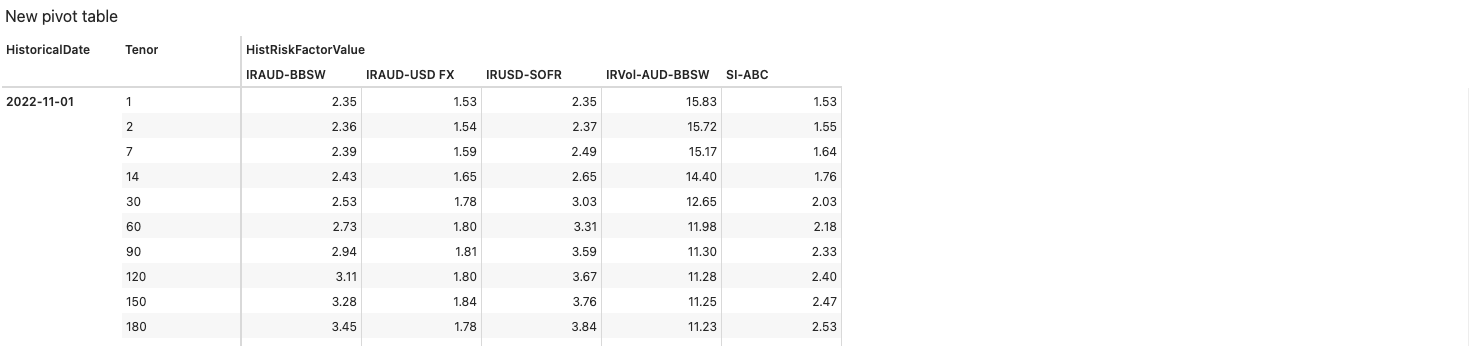

In [14]:
# Sample of 1-day Historical Rate Curves
session.widget

#### The stress period rates data

B.16 The one-year stressed period is the period that would result in the largest IRRBB capital charge based on the ADI’s current banking book. An ADI must assess the appropriateness of the choice of stressed period at least annually. If the ADI changes the choice of the stressed period, they must notify and provide supportive analysis to APRA justifying the appropriateness of the change in stressed period.

B.17 If an ADI materially changes their banking book profile (including the maturity profile for shareholders’ equity), then the ADI must update the eight-year observation period immediately. At the time of the update, the ADI must also perform an assessment of the choice of stressed period, and must notify and provide supportive analysis to APRA justifying the reasons for the change in stressed period if applicable.

This notebook can be extended by adding an additional stress period table to perform the stressed IRRBB measures. 

### B.18-23 The prospective IRRBB Capital Charge Calculation

B.18 The economic value of the banking book or augmented banking book (see paragraph 30 of this Attachment) is the sum of the economic values of all items it contains.

B.19 The economic value (EV) of a banking book item, given a set of repricing assumptions and risk factor values, is:
a) for a non-market-related item, the net present value, as at the calculation date, of expected future notional cash flows (see paragraph 26 of this Attachment), using discount rates from the relevant NMR curve; and
b) for a market-related item, the fair value of the item, based on the relevant risk factor values.

B.20 An ADI’s prospective IRRBB capital charge is

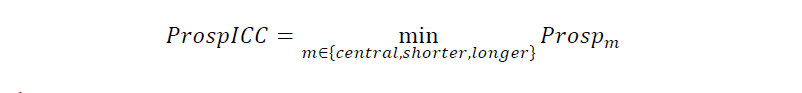

where Prospm is the ADI’s estimate of the 97.5 per cent expected shortfall of the prospective loss (The 97.5 per cent expected shortfall is the expected loss conditional on the loss being in the worst 2.5 per cent of potential losses.) under repricing assumptions 𝑚∈{ Central, shorter, longer }, where, for each possible rate scenario 𝑠 in the distribution of rate scenarios, the prospective loss is equal to:

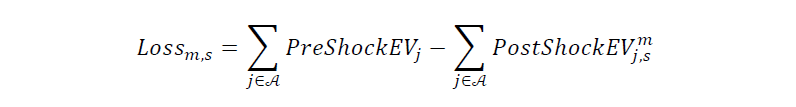

PreShockEV is the EV of item 𝑗 under the central assumptions, using the values of risk factors at the calculation date;

PostShockEV is the EV of item 𝑗 calculated using repricing assumptions 𝑚𝑚, together with simulated risk factor values obtained by applying to risk factors at the calculation date, a shock determined for rate scenario 𝑠 in accordance with paragraph 21 of this Attachment;
𝒜 is the augmented banking book (see paragraph 30 of this Attachment);

Note that PostShockEV is a random variable, whereas PreShockEV is not.

#### Historical scenario calculation
B.21 The distribution of each PostShockEV must be estimated using a simulation method under which:

a) the ADI designates every risk factor to be either perturbed or derived. This designation forms part of the approved IRRBB model, must be documented, and any change to it constitutes a model change;

b) there is one simulated scenario for each observation date;

c) for each perturbed risk factor and observation date, the simulated value of the risk factor to be used in the scenario for that observation date is:

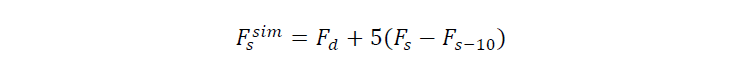

where the simulated value is equal to caluclation date value plus 5 times difference of observation date and 10 business days before the observation date values. 

d) for each derived risk factor and observation date, the ADI must derive the simulated value of the risk factor at that date to be used in the scenario from the values simulated for other risk factors for the scenario.

In [15]:
# Historical Scenario calculation

m["Δ of risk factor"] = m["Δ of risk factor.VECTOR"][m["HistoricalDate index"]]
m["SimulatedRate"] = m["SimulatedRate.VECTOR"][m["HistoricalDate index"]]

m["Δ of risk factor"].formatter = "DOUBLE[0.0000000000]"
m["SimulatedRate"].formatter = "DOUBLE[0.0000000000]"

**1-year Simulated Historical Cash Rate Scenario**

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
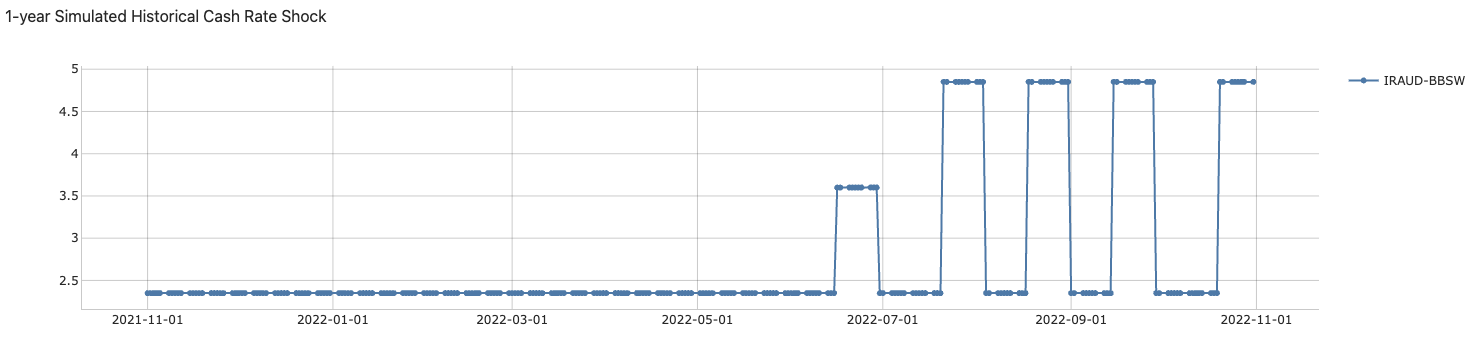

In [16]:
# 1-year Simulated Historical Cash Rate Shock
session.widget

#### Non-market-related items calculation
B.22 For non-market-related items, only the risk factor values in the NMR curves that are used to discount notional cash flows may differ between the calculation of Pre-shock and Post-shock EVs for a given set of repricing assumptions (see paragraph 26 of this Attachment). The notional cash flows in the Pre-shock and Post-shock EVs must be the same, other than for items with optionality, and for which APRA has approved a different treatment under paragraph 35 of this Attachment.

In order to fulfil B.22 and consolidate the calcuation with market related items. This notebook calculates the basis point value for each buckets. Basis point value denotes the changes in the price of a bond given a basis point change in the bond yield. A measure of price volatility of bond prices to 0.01% or 1 basis point change in its yield is called as BPV. The BPV will then apply on the non-market related items cash flows to calculate the sensitivity to the rate movement. 

In [17]:
# Tenor expressed as number of years (convention = actual/365)

m["Tenor"] = tt.agg.single_value(tbls.tenorsTbl["Tenor"])
m["TenorPerYear"] = ((m["Tenor"] * 10000000000) / 365) / 10000000000
m["TenorPerYear"].formatter = "DOUBLE[#,###.0000000000000]"

In [18]:
# Calculate the current discount factors

m["DiscountFactors"] = tt.agg.single_value(
    1 / (1 + m["CurrentRiskFactorValue"] / 100) ** m["TenorPerYear"],
    scope=tt.OriginScope({l["RiskMeasure"], l["RiskFactor"]}),
)

m["DiscountFactors"].formatter = "DOUBLE[#,###.0000000000000]"

In [19]:
# Calculate the current discount factors with 1bp bump

bp = 0.01
m["DiscountFactors+1bp"] = tt.agg.single_value(
    1 / (1 + (m["CurrentRiskFactorValue"] + bp) / 100) ** m["TenorPerYear"],
    scope=tt.OriginScope({l["RiskMeasure"], l["RiskFactor"]}),
)

m["DiscountFactors+1bp"].formatter = "DOUBLE[#,###.0000000000000]"

In [20]:
# Calculate the BPV per $1mil

bpf = 1000000
m["BPV"] = bpf * (m["DiscountFactors+1bp"] - m["DiscountFactors"])
m["BPV"].formatter = "DOUBLE[#,###.0000000000000]"

Following table displays the detail of the BPV calculation for each tenors

In [21]:
cube.query(
    m["CurrentRiskFactorValue"],
    m["DiscountFactors"],
    m["DiscountFactors+1bp"],
    m["BPV"],
    levels=[l["RiskFactor"], l["Tenor"]],
    filter=(l["RiskFactor"] == "IRAUD-BBSW"),
)

CurrentRiskFactorValue DiscountFactors DiscountFactors+1bp  \
RiskFactor Tenor                                                              
IRAUD-BBSW 1                       2.35  .9999363633232      .9999360956713   
           2                       2.35  .9998724907410      .9998719554949   
           7                       2.38  .9995495914073      .9995477190620   
           14                      2.41  .9990876416784      .9990838998687   
           30                      2.48  .9979885348964      .9979805311762   
           60                      2.67  .9956858684289      .9956699267634   
           90                      2.85  .9930948312452      .9930710239667   
           120                     3.01  .9902974960150      .9902658916794   
           150                     3.17  .9872567165659      .9872173936816   
           180                     3.33  .9839753675304      .9839284099122   
           210                     3.38  .9810728068806      .9810182096592   
           240                     3.42  .9781057798714      .9780436002826   
           270                     3.47  .9750749734373      .9750052701253   
           365                     3.62  .9650646593322      .9649715333398   
           455                     3.63  .9564694719537      .9563544351028   
           545                     3.65  .9478841265164      .9477475930631   
           635                     3.66  .9393097517502      .9391521348667   
           720                     3.68  .9312228103014      .9310456595989   
           900                     3.71  .9141373083141      .9139199999279   
           1095                    3.74  .8956973081528      .8954383363036   
           1461                    3.84  .8599869497754      .8596555297250   
           1825                    3.94  .8243021594231      .8239057459653   
           2555                    4.02  .7590999435543      .7585892858884   
           3650                    4.13  .6671773839049      .6665370063715   

                                 BPV  
RiskFactor Tenor                      
IRAUD-BBSW 1         -.2676519285094  
           2         -.5352461506236  
           7        -1.8723452998026  
           14       -3.7418096202613  
           30       -8.0037201607430  
           60      -15.9416654507138  
           90      -23.8072785136989  
           120     -31.6043356751727  
           150     -39.3228842775484  
           180     -46.9576182463571  
           210     -54.5972214195389  
           240     -62.1795887625343  
           270     -69.7033119690937  
           365     -93.1259924087380  
           455    -115.0368508071598  
           545    -136.5334532679174  
           635    -157.6168835105696  
           720    -177.1507025569719  
           900    -217.3083862191394  
           1095   -258.9718492498338  
           1461   -331.4200504286324  
           1825   -396.4134578090528  
           2555   -510.6576659215101  
           3650   -640.3775334000717

#### Market related items calculation
B.23 For market-related items, Post-shock EVs must be determined using either full revaluation or a sensitivity-based method approved by APRA. Risk factors whose values differ between the calculations of Pre-shock and Post-shock EVs are not limited to discount curves. Where a counterparty to an item, including an ADI customer, may exercise a choice in relation to the item, the ADI must assume the counterparty will exercise the choice in the way that is most adverse to the ADI.

This notebook adopts the sensitivity-based method calculation.

In [22]:
# Decompose the sensitivities vectors to corresponding tenor

m["DeltaSensitivities.VECTOR"] = tt.agg.sum(tbls.irDeltaTbl["DeltaSensitivities"])

m["DeltaSensitivities"] = tt.agg.sum(
    m["DeltaSensitivities.VECTOR"][m["TenorIndex"]],
    scope=tt.OriginScope({l["Tenor"], l["RiskFactor"], l["TradeID"], l["ProductType"]}),
)

m["SIDeltaSensitivities.VECTOR"] = tt.agg.sum(tbls.siDeltaTbl["SIDeltaSensitivities"])
m["SIDeltaSensitivities"] = tt.agg.sum(
    m["SIDeltaSensitivities.VECTOR"][m["TenorIndex"]],
    scope=tt.OriginScope({l["Tenor"], l["RiskFactor"], l["TradeID"], l["ProductType"]}),
)

m["VegaSensitivities.VECTOR"] = tt.agg.sum(tbls.irVegaTbl["VegaSensitivities"])
m["VegaSensitivities"] = tt.agg.sum(
    m["VegaSensitivities.VECTOR"][m["TenorIndex"]],
    scope=tt.OriginScope({l["Tenor"], l["RiskFactor"], l["TradeID"], l["ProductType"]}),
)

cube.query(
    m["DeltaSensitivities"],
    m["VegaSensitivities"],
    m["SIDeltaSensitivities"],
    levels=[l["ProductType"]],
)

,DeltaSensitivities,VegaSensitivities,SIDeltaSensitivities
ProductType,,,
Bonds,"-148,569.68",,"-147,486.36"
FRN,"-187,590.86",,
IRSwap,"7,827.28",,
Swaption,"-67,723.00","1,002.13",
XCCYSwap,"-9,588.02",,


Following table shows the sensitivities by trades, risk factors and tenor

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
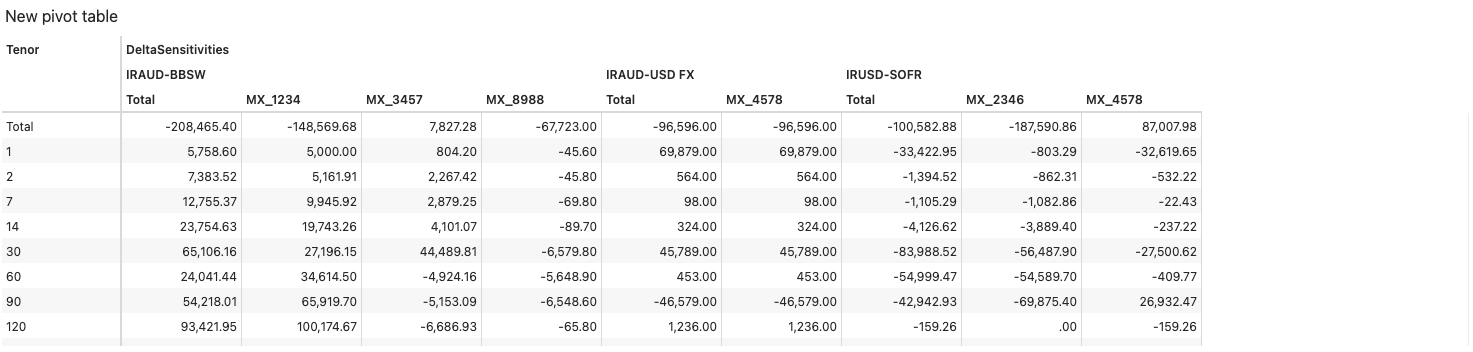

In [23]:
# Sensitivities by trades, risk factors and tenor
session.widget

### B.24-38 Repricing Assumptions

#### Central assumptions
B.26 An ADI must have a method of allocating a cash flow profile to each non-market-related item, consisting of a series of notional cash flows and associated dates at which they are assumed to occur.

B.27 The total value at a non-market-related item’s inception date of all its notional cash flows, each discounted using the NMR curve for its currency, must equal the consideration paid to establish the item, or the initial book value of the item if there is no such consideration.

B.28 The notional cash flows of a principal-and-interest item must be classified into notional principal cash flows and notional interest cash flows. The repricing profile of a principal-and-interest item is the set of notional principal cash flows and associated dates, which are called repricing dates. At any date, the future notional principal cash flows must sum to the principal then outstanding.

B.29 An ADI must have a documented method of determining the notional interest cash flows of a principal-and-interest item based on its notional principal cash flows, such that:
a) the notional interest cash flows occur on the dates upon which interest is actually required to be paid under the item, except that a notional interest cash flow associated with any notional principal cash flow occurring on the next business day after the calculation date may occur at the same time as the notional principal cash flow; and
b) projections of notional interest cash flows may be changed only to the extent that the change is necessitated by changes to the item’s repricing profile.

B.30 An ADI’s augmented banking book is the ADI’s banking book together with an earnings offset, which is a notional principal and interest item. For the earnings offset, the ADI must choose a repricing profile consisting of at least twelve outgoing notional principal cash flows, spaced evenly over the year following the calculation date, each of magnitude one-twelfth the book value of the banking book at the calculation date. Notional interest cash flows on the earnings offset must be determined in accordance with paragraphs 27 to 29 of this Attachment as if the earnings offset were incepted at the calculation date and a notional principal cash flow occurs, equal to all unpaid, accrued interest at that time.

B.31 For each type of core deposit, the repricing profile of the portfolio of all core deposits of that type must consist of a non-increasing series of notional principal cash flows spaced evenly over the period from the calculation date to the last in the series, which must be no more than five years after the calculation date.

B.32 For all non-maturity deposits that are not core deposits, the repricing profile must have only one notional principal cash flow, occurring on the next business day after the calculation date, unless APRA approves an alternative treatment.

B.33 An ADI must choose the repricing date of each notional principal cash flow of an OPI item as the earliest date at which:
a) the ADI has the right to change the interest rate on the principal, or the rate is contractually required to be reset in line with an external benchmark; or
b) the cash flow will be paid, based on: 1) if the ADI designates the OPI item to have a contractual repricing profile, an assumption that all principal payments occur at the contractually-scheduled dates; 2) if the ADI designates the OPI item to have a behavioural repricing profile, an assumption that the timing of all principal payments will be in line with best estimate expectations in the case of payments that do not attract economic adjustments for the impact of breaking term, and with the contractually scheduled dates for payments that would otherwise attract such economic adjustments.

B.34 An ADI must designate an OPI item to have a repricing profile that is: a) contractual for a deposit, unless agreed otherwise with APRA; and b) behavioural for all non-deposit items, except that: 1) contractual may be used if significant deviation from the contractual repricing profile is not expected; and 2) contractual must be used if there is insufficient relevant data on which to base a behavioural repricing profile.

B.35 Where an ADI has designated as a non-market-related item any non-linear derivative such as swaptions, caps or floors, whether stand-alone or embedded in other instruments, the ADI must use a method that APRA has explicitly approved to measure IRRBB on that item.

B.36 An ADI’s repricing assumptions form part of its approved IRRBB model and must be clearly documented, conceptually sound, reasonable and, except where compelling reasons are provided to do otherwise, consistent with historical experience.

B.37 APRA may review the appropriateness of an ADI’s repricing assumptions and may require the ADI to use different assumptions for the purpose of determining its IRRBB capital charge.

In [24]:
# Create a parameter for Stress Behaviour

cube.create_parameter_hierarchy_from_members(
    "StressBehaviour",
    ["Central", "Shorter", "Longer"],
)

h["StressBehaviour"].slicing = True
l["StressBehaviour"].order = tt.CustomOrder(
    first_elements=["Central", "Shorter", "Longer"]
)

In [25]:
# Decompose the non-market related cash flows to tenor

m["CashFlowValues.VECTOR"] = tt.agg.sum(tbls.nmrCashFlowTbl["CashFlowValues"])
m["CashFlow"] = tt.agg.sum(
    m["CashFlowValues.VECTOR"][m["TenorIndex"]],
    scope=tt.OriginScope({l["Tenor"], l["RiskFactor"], l["TradeID"], l["ProductType"]}),
)

#### Shorter and longer assumptions
B.38 The shorter and longer assumptions are used to take account of the most common sources of optionality risk where customer payments differ from what was assumed in a behavioural repricing profile. These assumptions must be the same as the central assumptions for all items except fixed-rate assets, rate locks and core deposits, for which the differences are:

a) for notional principal cash flows: 
1) each prepayment rate CPR that is used in determining the repricing profile for fixed-rate, non-market-related assets must be determined as:

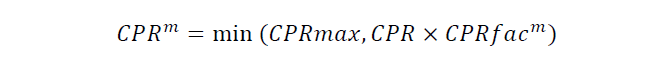

where CPR is the corresponding prepayment rate used in the central assumptions, CPRmax is the highest possible prepayment rate, and the factor CPRfac is specified in Table 1;

2) each drawdown rate DD that is used in determining the repricing profile for a rate lock must be determined as:

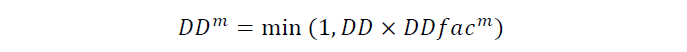

where DD is the corresponding drawdown rate used in the central assumptions and the factor DDfac is specified Table 1;

3. for a core deposit, the notional principal cash flow at any date 𝑡 that is more than one business day after the calculation date is:

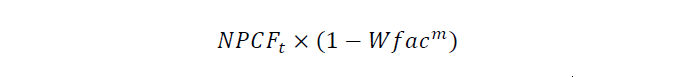

where NPCF is the corresponding notional principal cash flow for that date in the central assumptions, Wfac is specified in Table 1 and the balance of the principal is assumed to reprice on the next business day after the calculation date.

b) all notional interest cash flows must be recalculated to be consistent with the revised notional principal cash flows, in accordance with paragraph 29 of this Attachment.

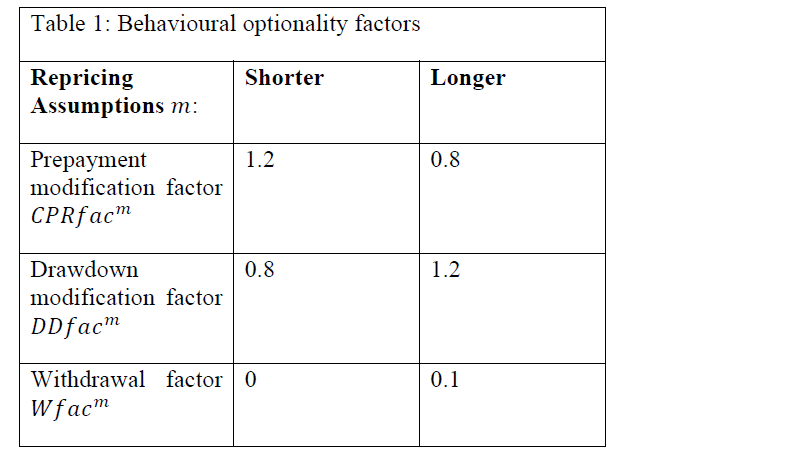

In [26]:
# Summarise the cash flow details by stress scenarios
m["CashFlowValues"] = tt.filter(
    tt.switch(
        l["StressBehaviour"],
        {
            "Central": tt.filter(m["CashFlow"], l["BehaviourOption"] == "Normal"),
            "Shorter": tt.filter(m["CashFlow"], l["BehaviourOption"] == "Shorter"),
            "Longer": tt.filter(m["CashFlow"], l["BehaviourOption"] == "Longer"),
        },
        default=m["CashFlow"],
    ),
    l["BehaviourOptionalityStressedCF"] == "Y",
) + tt.filter(m["CashFlow"], l["BehaviourOptionalityStressedCF"] != "Y")

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
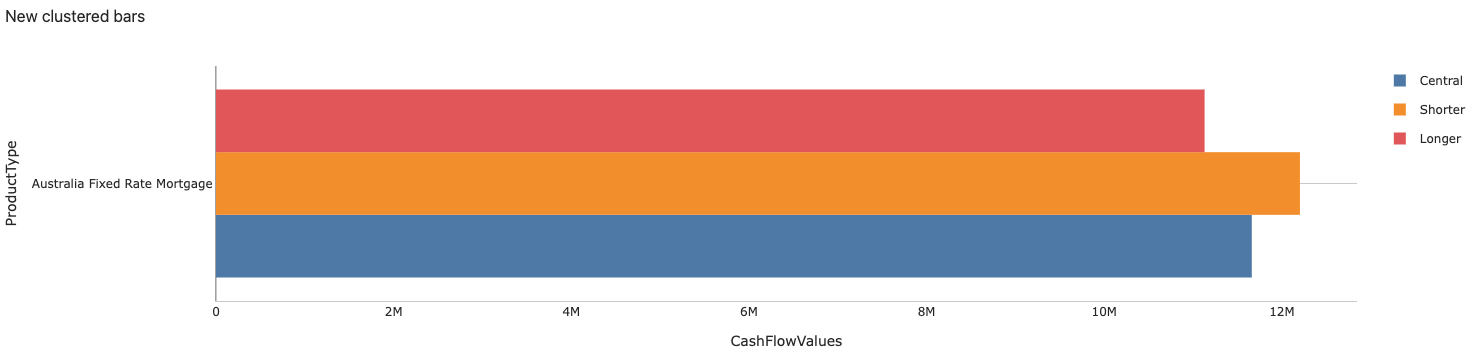

In [27]:
# FixedRateMortgage Cashflow in the first bucket by various behaviour options
session.widget

##### Calculate the cash flow sensitivities

In [28]:
# Calculate the cash flow sensitivities
m["CashflowSensitivities"] = tt.agg.sum(
    m["CashFlowValues"] * m["BPV"] / 1000000,
    scope=tt.OriginScope({l["Tenor"], l["RiskFactor"], l["TradeID"], l["ProductType"]}),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
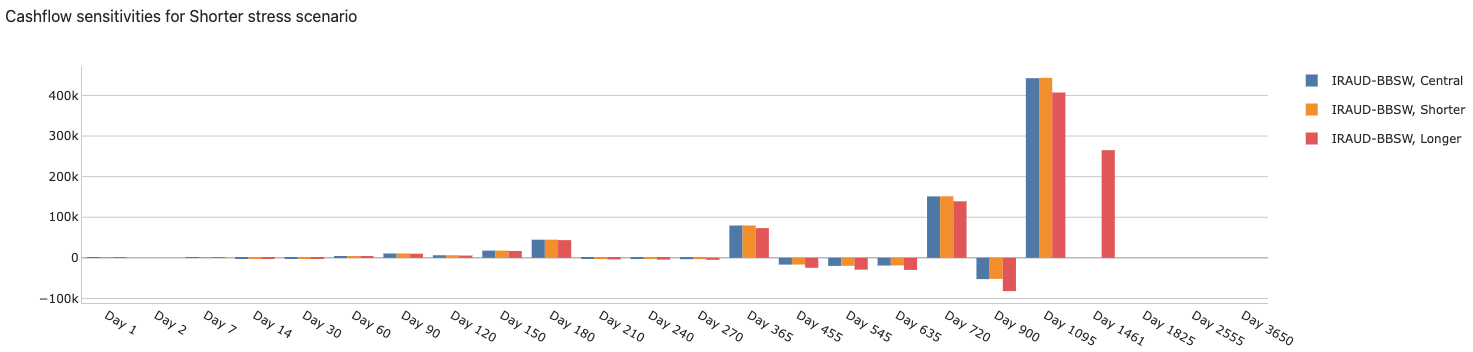

In [29]:
# Cashflow sensitivities by stress scenario
session.widget

##### Combining all market related and non-market related items sensitivities

In [30]:
# Summarising Sensitivities

m["Sensitivities"] = tt.where(
    ~l["RiskFactor"].isnull(),
    tt.switch(
        l["ItemType"],
        {
            "Market-related": (
                m["DeltaSensitivities"]
                + m["VegaSensitivities"]
                + m["SIDeltaSensitivities"]
            ),
            "Non-Market-related": m["CashflowSensitivities"],
        },
    ),
)

m["Sensitivities"].formatter = "DOUBLE[#,###.0000000000000]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
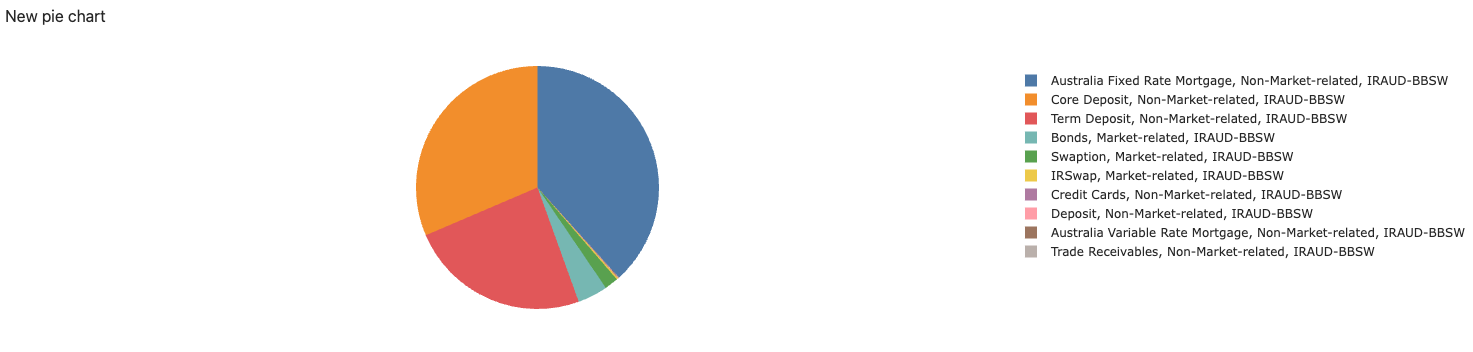

In [31]:
# Total Sensitivity by Product Type and one risk factor
session.widget

In [32]:
# Summarising the sensitivities by risk factors

m["SensitivitiesByRF"] = tt.agg.sum(
    m["Sensitivities"],
    scope=tt.OriginScope({l["RiskFactor"], l["ItemType"]}),
)
m["SensitivitiesByRF"].formatter = "DOUBLE[#,###.0000000000000]"

##### Calculate the historical simulated P&L

In [33]:
# Calculate the historical simulated P&L for each historical data date
m["HistoricalPnL"] = tt.agg.sum(
    tt.where(
        m["HistoricalDate index"] > 0,
        m["SensitivitiesByRF"] * m["Δ of risk factor"] * 100,
    ),
    scope=tt.OriginScope(
        {
            l["Tenor"],
            l["RiskFactor"],
            l["StressBehaviour"],
            l["HistoricalDate"],
            l["TradeID"],
        }
    ),
)


m["HistoricalPnL"].formatter = "DOUBLE[#,###.0000000000000]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
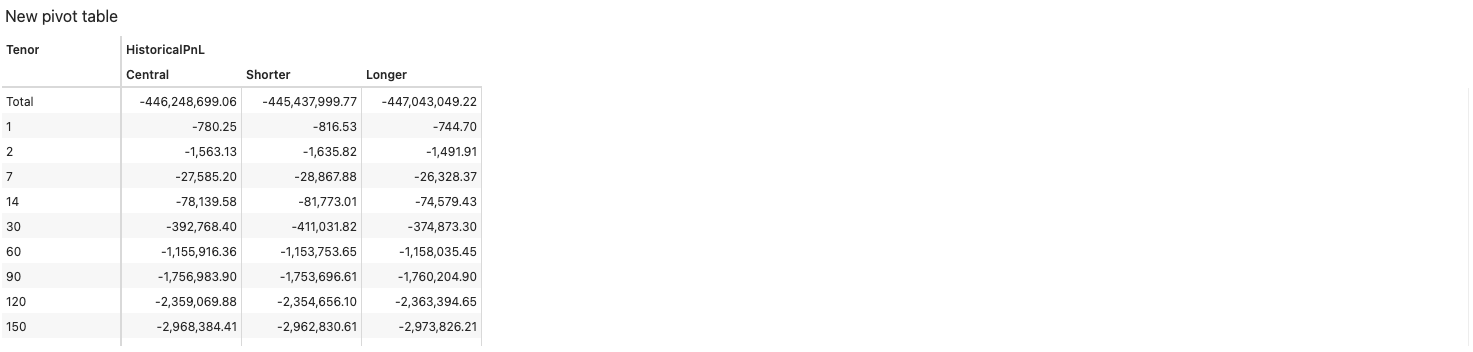

In [34]:
# One scenario historical PnL for various behaviour assumptions
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
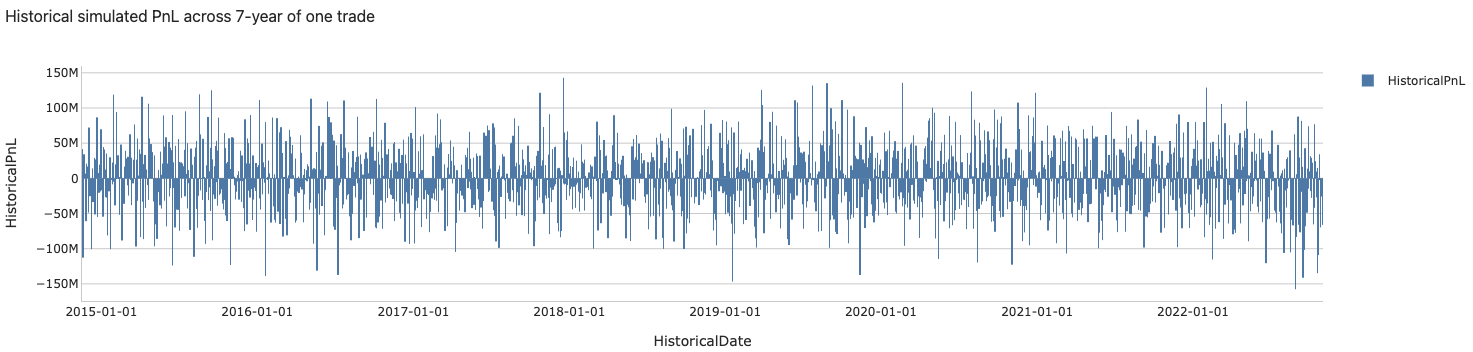

In [35]:
# Historical simulated PnL across 7-year of one trade
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
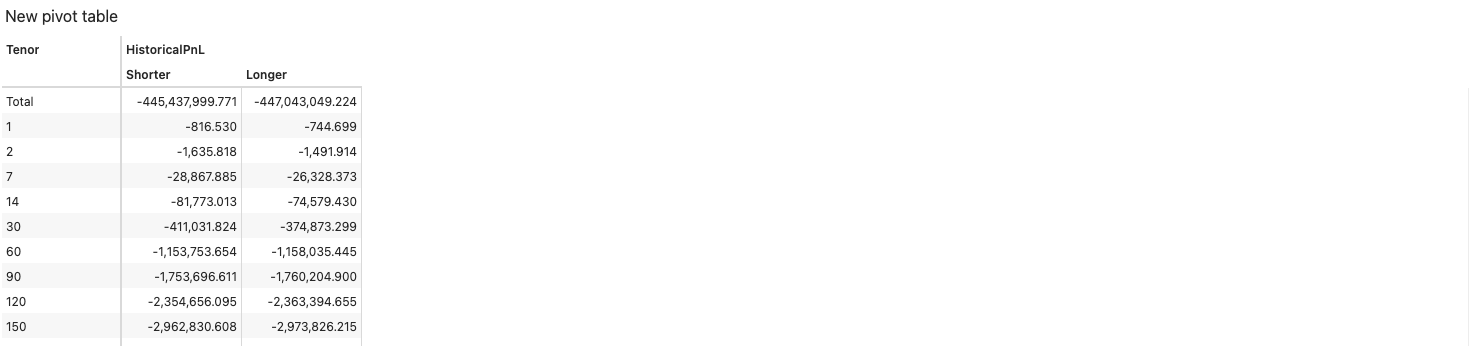

In [36]:
# Historical PnL comparison between Longer and Shorter scenario for Mortgage
session.widget

## Create new cube to compute Historical VaR, Expected Shortfall and IRRBB Capital Charge

Atoti supports multiple cubes within a session. We can make use of the aggregated from one cube to create another cube, hence improving performance without having to re-compute on every query.  

In [37]:
historicalPnL_df = cube.query(
    m["HistoricalPnL"],
    levels=[
        l["InternalKey"],
        l["AsOfDate"],
        l["StressBehaviour"],
        l["HistoricalDate"],
        l["ParentBook"],
        l["SubParentBook"],
        l["Book"],
        l["TradeID"],
        l["RiskFactor"],
    ],
    timeout=datetime.timedelta(seconds=600),
).reset_index()

print(historicalPnL_df.shape)

historicalPnL_df.head()

(99696, 10)


,InternalKey,AsOfDate,StressBehaviour,HistoricalDate,ParentBook,SubParentBook,Book,TradeID,RiskFactor,HistoricalPnL
0,20221102Cards_6578IRAUD-BBSWDiscount,2022-11-02,Central,2014-11-17,Cards,Cards,Credit Cards,Cards_6578,IRAUD-BBSW,15044.315958
1,20221102Cards_6578IRAUD-BBSWDiscount,2022-11-02,Central,2014-11-18,Cards,Cards,Credit Cards,Cards_6578,IRAUD-BBSW,27221.485925
2,20221102Cards_6578IRAUD-BBSWDiscount,2022-11-02,Central,2014-11-19,Cards,Cards,Credit Cards,Cards_6578,IRAUD-BBSW,-73796.885226
3,20221102Cards_6578IRAUD-BBSWDiscount,2022-11-02,Central,2014-11-20,Cards,Cards,Credit Cards,Cards_6578,IRAUD-BBSW,-36313.233678
4,20221102Cards_6578IRAUD-BBSWDiscount,2022-11-02,Central,2014-11-21,Cards,Cards,Credit Cards,Cards_6578,IRAUD-BBSW,22365.537802


In [38]:
es_tbl = session.read_pandas(
    historicalPnL_df,
    table_name="Expected Shortfall",
    keys=["InternalKey", "StressBehaviour", "HistoricalDate"],
)

# verify the data loaded into the sub-cube is correct
print("No. of rows: ", es_tbl.row_count, "No. of columns: ", list(es_tbl))

No. of rows:  99696 No. of columns:  ['InternalKey', 'AsOfDate', 'StressBehaviour', 'HistoricalDate', 'ParentBook', 'SubParentBook', 'Book', 'TradeID', 'RiskFactor', 'HistoricalPnL']


### Enrich sub-cube with simulated rate value

In [39]:
simulatedRate_df = cube.query(
    m["SimulatedRate"],
    levels=[l["HistoricalDate"], l["RiskFactor"]],
    timeout=datetime.timedelta(seconds=600),
)
simulatedRate_df.head()

SimulatedRate
HistoricalDate RiskFactor                   
2014-11-17     IRAUD-BBSW           69.94827
               IRAUD-USD FX        46.561282
               IRUSD-SOFR          92.087904
               IRVol-AUD-BBSW     381.815246
               SI-ABC                78.2063

In [40]:
simulatedRate_tbl = session.read_pandas(
    simulatedRate_df, table_name="Simulated Rate", keys=["HistoricalDate", "RiskFactor"]
)

es_tbl.join(
    simulatedRate_tbl,
    (es_tbl["HistoricalDate"] == simulatedRate_tbl["HistoricalDate"])
    & (es_tbl["RiskFactor"] == simulatedRate_tbl["RiskFactor"]),
)

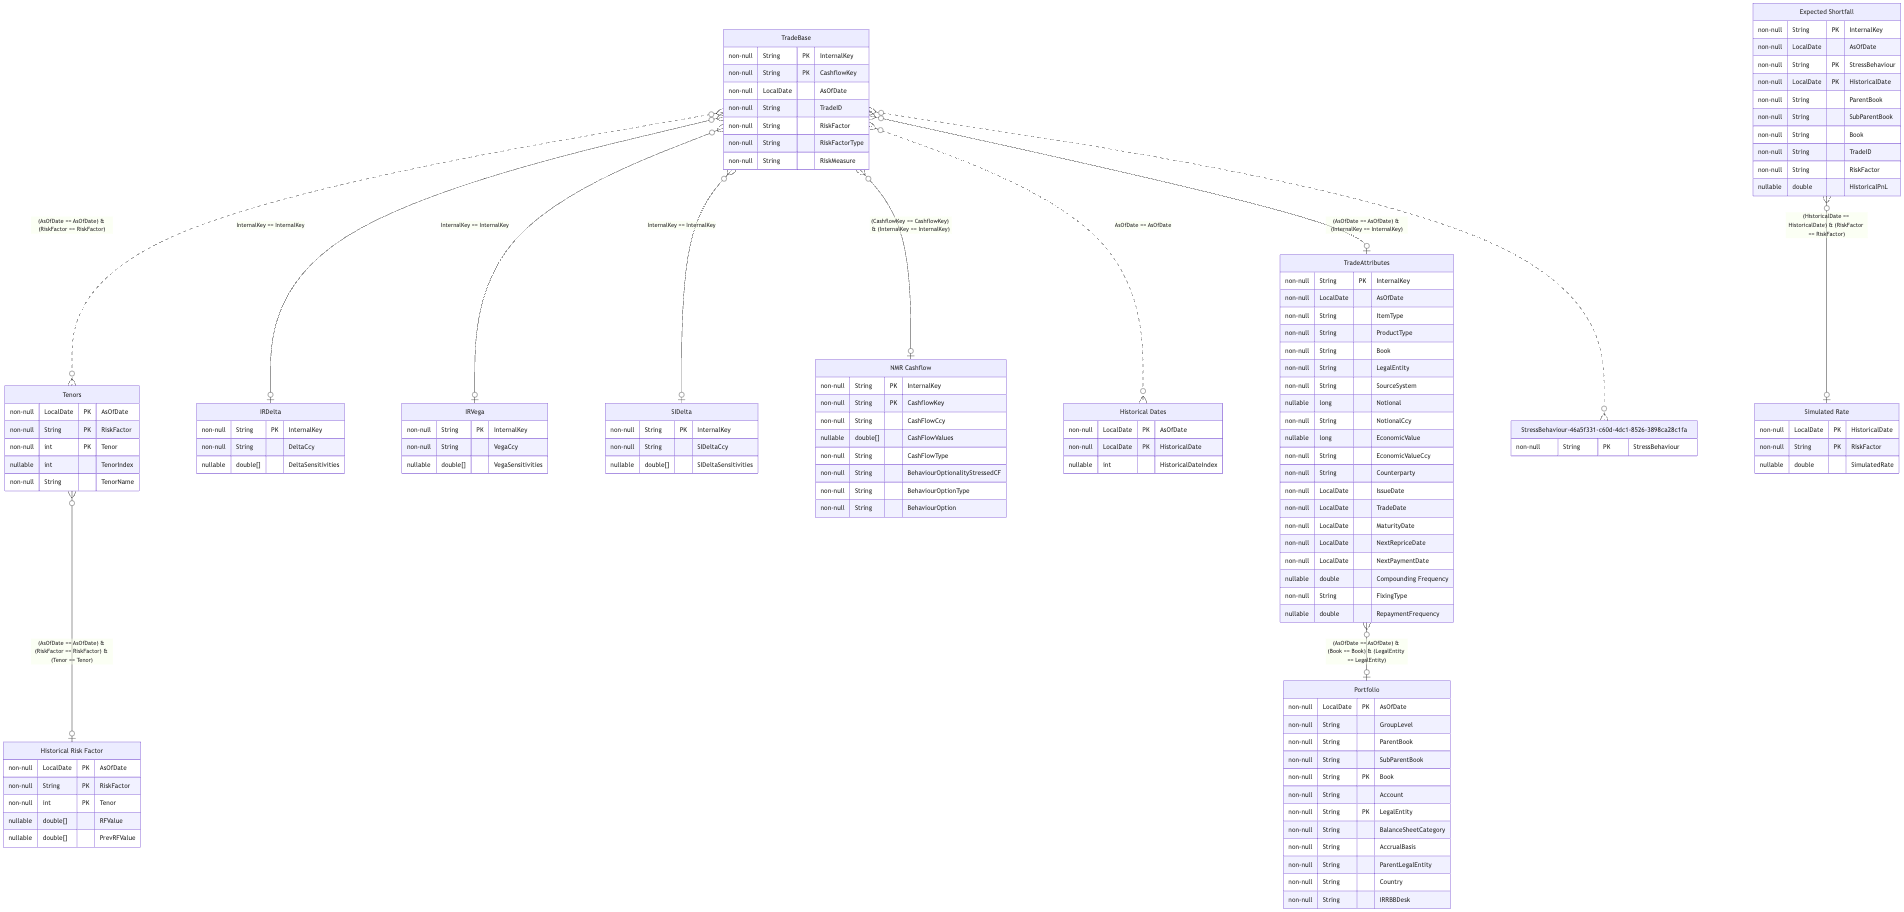

In [41]:
cube_cc = session.create_cube(es_tbl, name="Capital Charge", mode="no_measures")
session.tables.schema

In [42]:
h_cc, l_cc, m_cc = cube_cc.hierarchies, cube_cc.levels, cube_cc.measures

# Setting slicing to true for stress behaviour
# Historical PnL shouldn't be aggregated across different stress scenarios
h_cc["StressBehaviour"].slicing = True

The second cube is created with `mode="no_measures"`. Therefore, we have to manually create the measures we needed.  

In [43]:
m_cc["HistoricalPnL"] = tt.agg.sum(es_tbl["HistoricalPnL"])

m_cc["SimulatedRate"] = tt.agg.sum(simulatedRate_tbl["SimulatedRate"])
m_cc["SimulatedRate"].formatter = "DOUBLE[0.0000000000]"

### Calculate the historical VaR from the simulated P&L

In [44]:
m_cc["HistoricalVaR"] = tt.agg.quantile(
    m_cc["HistoricalPnL"],
    0.05,
    mode="simple",
    interpolation="lower",
    scope=tt.OriginScope({l_cc["HistoricalDate"]}),
)

m_cc["HistoricalVaR"].formatter = "DOUBLE[#,##0.00]"

In [45]:
# we remove 1 date due to the current date in the list
m_cc["HistoricalDateCount"] = (
    tt.agg.sum(
        tt.where((~m_cc["HistoricalVaR"].isnull()), 1),
        scope=tt.OriginScope({l_cc["HistoricalDate"]}),
    )
    - 1
)

### Calculate the Expected Shortfalls

In [46]:
m_cc["ConfidenceLevel"] = 0.975
m_cc["TailExposures"] = tt.total(
    tt.math.floor((1 - m_cc["ConfidenceLevel"]) * m_cc["HistoricalDateCount"]),
    h_cc["HistoricalDate"],
)

m_cc["Rank"] = tt.rank(m_cc["HistoricalPnL"], h_cc["HistoricalDate"])

m_cc["ExpectedShortfall"] = tt.agg.mean(
    tt.where(m_cc["Rank"] <= m_cc["TailExposures"], m_cc["HistoricalPnL"]),
    scope=tt.OriginScope({l_cc["HistoricalDate"]}),
)

m_cc["ExpectedShortfall"].formatter = "DOUBLE[#,##0.00]"

In [47]:
cube_cc.query(m_cc["ExpectedShortfall"], levels=[l_cc["RiskFactor"]])

,ExpectedShortfall
RiskFactor,
IRAUD-BBSW,"-64,314,493.18"
IRAUD-USD FX,"-6,954,794.41"
IRUSD-SOFR,"-3,620,922.43"
IRVol-AUD-BBSW,"-1,241,366.64"
SI-ABC,"-10,618,838.23"


**Historical VaR by trades**

In [48]:
cube_cc.query(m_cc["HistoricalVaR"], levels=[l_cc["TradeID"]])

,HistoricalVaR
TradeID,
Cards_6578,"-55,793.53"
Deposits_1234,0.00
Deposits_4466,"-162,063,597.33"
Deposits_Core,"-203,947,727.85"
MX_1234,"-76,221,641.12"
MX_2346,"-4,561,787.13"
MX_3457,"-1,817,397.85"
MX_4578,"-2,582,156.21"
MX_8988,"-8,149,325.74"


**Expected Shortfalls by trades**

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
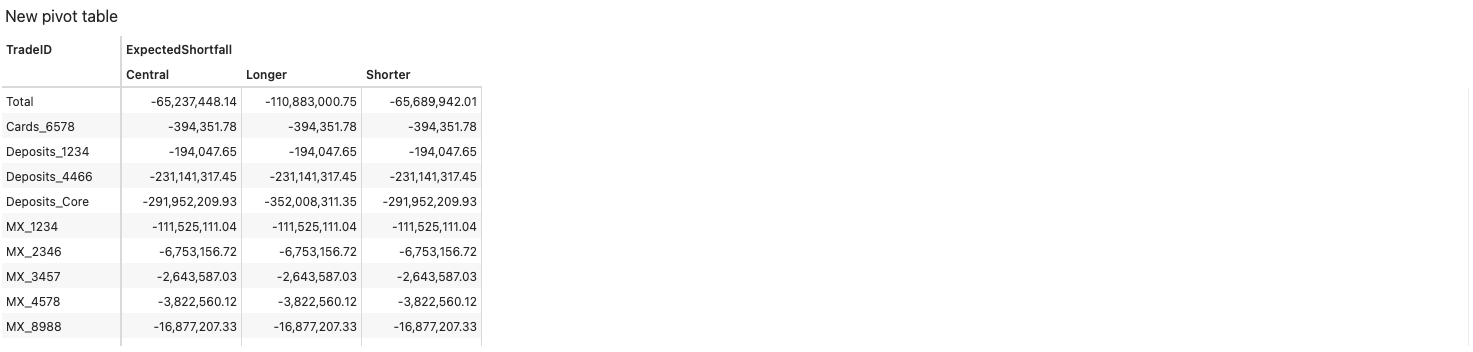

In [49]:
# Expected Shortfalls by trade in all behaviour scenario
session.widget

### Prospective IRRBB Capital Charge (ProspICC)

In [50]:
m_cc["ProspICC"] = tt.agg.min(
    m_cc["ExpectedShortfall"],
    scope=tt.SiblingsScope(hierarchy=h_cc["StressBehaviour"]),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
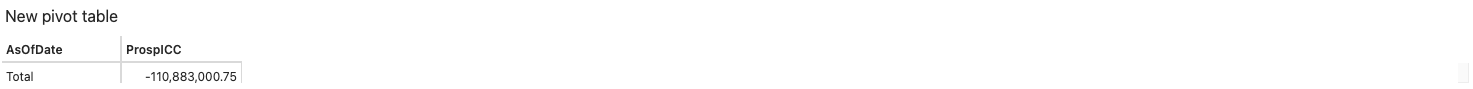

In [51]:
# Overall Prospective ICC
session.widget

### B.39-40 Additional optionality risk
B.39 An ADI must assess, at inception and at least annually, any risk to which it is exposed to from sources of optionality risk not captured by paragraphs 20 or 35 of this Attachment and determine whether the potential loss from all such sources is material. Where the loss is assessed as material, the ADI must extend its approved IRRBB model to determine a capital charge for those losses, which is the optionality capital charge. That capital charge must meet a soundness standard whereby it is no less than the 97.5 per cent expected shortfall from all such sources over a one-year period. An ADI must also assess new products and variations of existing products as to whether they introduce material additional optionality risk.

B.40 For each independent review conducted in accordance with paragraph 31 of Attachment A to this Prudential Standard, an ADI must assess the materiality of its exposure to sources of optionality risk that are not covered by its approved IRRBB model.

In [52]:
tbls.setup_capitalCharge_cube()
data_processing.load_capitalCharge_data(tbls)

In [53]:
# ICC OCC and OAA calculation
l_cc["ICCcalculationDate"].order = tt.NaturalOrder(ascending=False)
l_cc["OCCcalculationDate"].order = tt.NaturalOrder(ascending=False)
l_cc["OAAcalculationDate"].order = tt.NaturalOrder(ascending=False)

### B.2-3 IRRBB capital charge

B.2 The IRRBB capital charge at a calculation date 𝑑𝑑 is the greater of zero and:

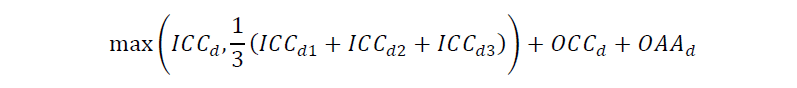

where:
ICCd, ICCd1, ICCd2, ICCd3 are respectively the prospective IRRBB capital charges at the calculation date and the latest three month-ends, determined in accordance with paragraph 20 of this Attachment;

OCCd is the optionality capital charge at the calculation date, determined in accordance with paragraph 39 of this Attachment; and

OAAd is any other amount that APRA has notified the ADI it must include in the calculation of its IRRBB capital charge, or that has been calculated in accordance with a method specified by APRA.

B.3 The IRRBB capital charge, as defined in paragraph 2 of this Attachment, excludes embedded loss. Embedded loss is the sum of the differences of the book value and economic value of each banking book item. Unless it has been written off to the ADI’s profit or loss, embedded loss is to be included as a regulatory adjustment (i.e. deduction) from an ADI’s Common Equity Tier 1 Capital under Attachment D of Prudential Standard APS 111 Capital Adequacy: Measurement of Capital. If the embedded loss is negative (i.e. embedded gain), the regulatory adjustment must be set to zero.

#### Overall IRRBB capital charge calculation

In [54]:
# Calculate the average of the last three IRRBB Capital Charge
m_cc["ICCValue"] = tt.agg.single_value(tbls.historcialICCTbl["ICCValue"])

m_cc["1PeriodLastICCValue"] = tt.agg.single_value(tbls.historcialICCTbl["ICCValue"])
m_cc["2PeriodLastICCValue"] = tt.agg.single_value(
    tbls.historcialICCTbl["2PeriodLastICCValue"]
)
m_cc["3PeriodLastICCValue"] = tt.agg.single_value(
    tbls.historcialICCTbl["3PeriodLastICCValue"]
)
m_cc["AvgLast3ICC"] = tt.agg.single_value(tbls.historcialICCTbl["AvgLast3ICC"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
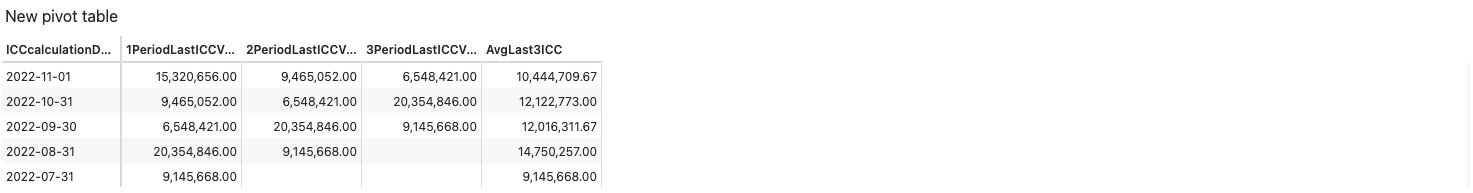

In [55]:
# ICC History
session.widget

In [56]:
# Calculate the IRRBB Capital Charge for this period
m_cc["OCCValue"] = tt.agg.single_value(tbls.optionalityChargeTbl["OCCValue"])
m_cc["LastOCCValue"] = tt.first(m_cc["OCCValue"], l_cc["OCCcalculationDate"])

m_cc["OAAValue"] = tt.agg.single_value(tbls.otherAPRAAmtTbl["OAAValue"])
m_cc["LastOAAValue"] = tt.first(m_cc["OAAValue"], l_cc["OAAcalculationDate"])

m_cc["CapitalChargeICCcomponent"] = tt.math.max(m_cc["ProspICC"], m_cc["AvgLast3ICC"])

In [57]:
m_cc["OverallIRRBBCapitalCharge"] = tt.agg.sum(
    m_cc["CapitalChargeICCcomponent"] + m_cc["LastOCCValue"] + m_cc["LastOAAValue"],
    scope=tt.OriginScope({l_cc["AsOfDate"]}),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
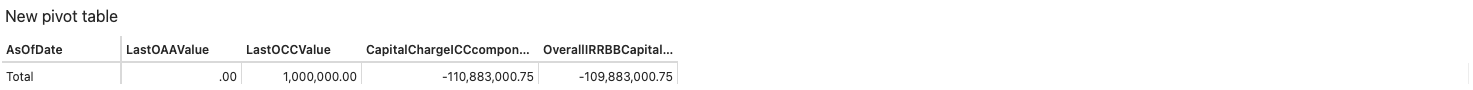

In [58]:
# Overall IRRBB Capital Calculation
session.widget

In [59]:
session.link

http://localhost:9102

## Conclusion

The notebook has demonstrated how the Interest Rate Risk Banking Book calculation can be performed within Atoti. The Atoti solution assists users to perform the analytics on various calculations within the standards. Through this, users can perform full data analytics of the risk numbers from bank level down to the trade level. 

Further data mapping of the trade to the bank’s desk portfolio, charts of accounts hierarchy, user can attribute the risk measures and historical simulated PnL in different hierarchies. Users can explain the source of risk and attribute the capital accordingly. 

The solution also demonstrated how users can compare the cash flows, sensitivities and risk results under various APRA behaviour stress assumptions. These can help provide relevant information for risk managment decision.  

This solution can be further extended for stress testing, backtesting, theoretical PnL explain, limit management and so on. 

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=irrbb" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>